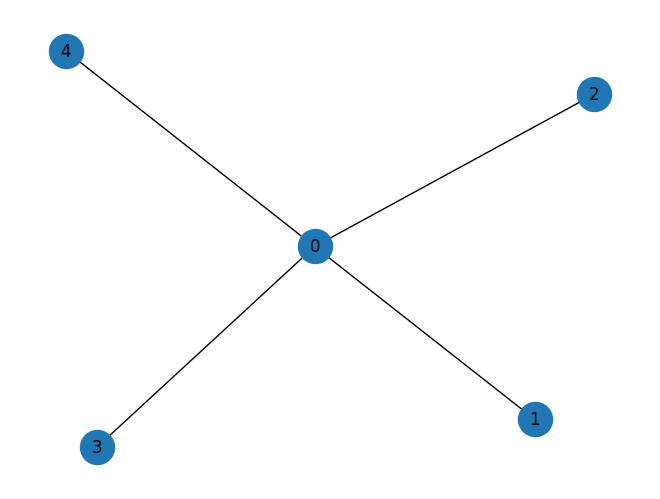

In [1]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np

n = 5

graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, n, 1))
edge_list = [(0, 1, 1.0), (0, 2, 1.0), (0, 3, 1.0), (0, 4, 1.0)]
graph.add_edges_from(edge_list)
draw_graph(graph, node_size=600, with_labels=True)

In [2]:
from qiskit.quantum_info import SparsePauliOp
def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, float]]:
    """Convert the graph to Pauli list.

    This function does the inverse of `build_max_cut_graph`
    """
    pauli_list = []
    for edge in list(graph.edge_list()):
        paulis = ["I"] * len(graph)
        paulis[edge[0]], paulis[edge[1]] = "Z", "Z"

        weight = graph.get_edge_data(edge[0], edge[1])

        pauli_list.append(("".join(paulis)[::-1], weight))

    return pauli_list


max_cut_paulis = build_max_cut_paulis(graph)

cost_hamiltonian = SparsePauliOp.from_list(max_cut_paulis)
print("Cost Function Hamiltonian:", cost_hamiltonian)

Cost Function Hamiltonian: SparsePauliOp(['IIIZZ', 'IIZIZ', 'IZIIZ', 'ZIIIZ'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


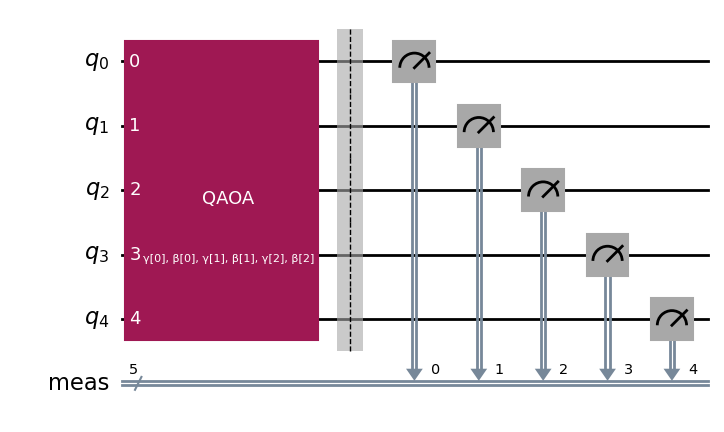

In [3]:
from qiskit.circuit.library import QAOAAnsatz

depth_circuit = 3
circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=depth_circuit)
circuit.measure_all()

circuit.draw('mpl')

AerSimulator('aer_simulator')


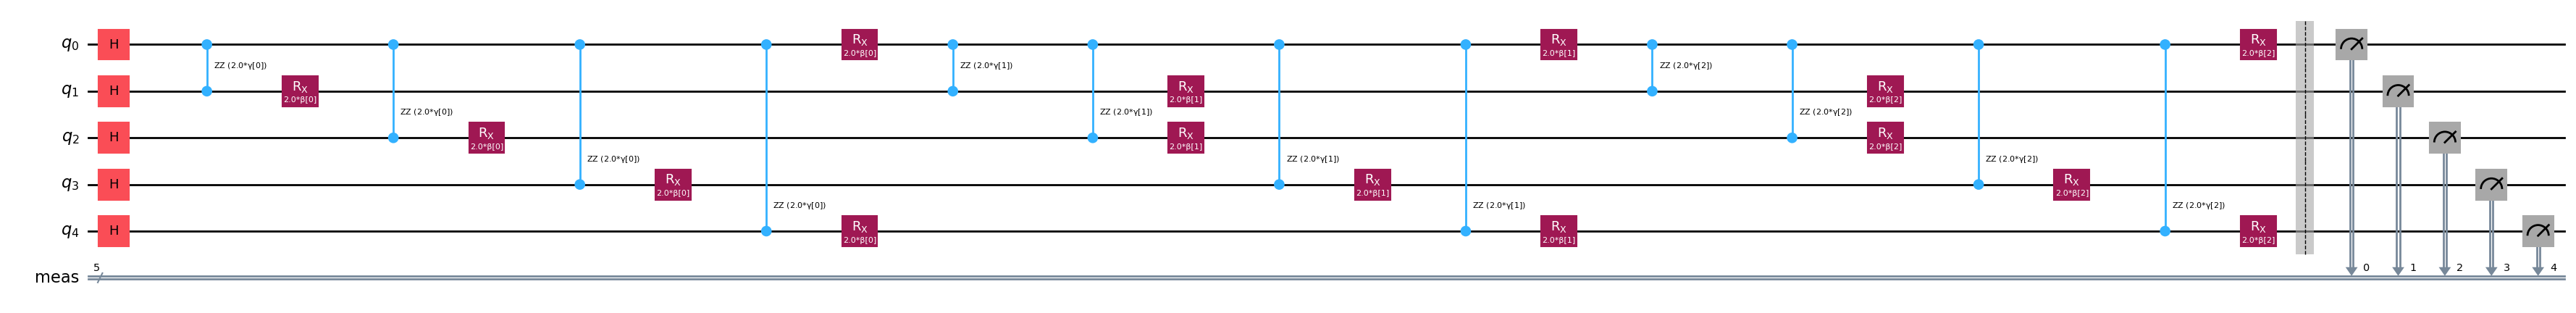

In [4]:
#from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator
backend = AerSimulator()


# QiskitRuntimeService.save_account(channel="ibm_quantum", token="<MY_IBM_QUANTUM_TOKEN>", overwrite=True, set_as_default=True)
#service = QiskitRuntimeService(channel='ibm_quantum')
#backend = service.least_busy(min_num_qubits=127)
print(backend)

# Create pass manager for transpilation
pm = generate_preset_pass_manager(optimization_level=0,
                                    backend=backend)

candidate_circuit = pm.run(circuit)
candidate_circuit.draw('mpl', fold=False, idle_wires=False)

In [5]:
initial_gamma = np.pi
initial_beta = np.pi/2
init_params = []
for i in range(depth_circuit):
    init_params.append(initial_gamma)
    init_params.append(initial_beta)

print(init_params)

[3.141592653589793, 1.5707963267948966, 3.141592653589793, 1.5707963267948966, 3.141592653589793, 1.5707963267948966]


In [6]:
def cost_func_estimator(params, ansatz, hamiltonian, estimator):

    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs
    print("cost is " + str(cost))
    objective_func_vals.append(cost)


    return cost

In [7]:
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from scipy.optimize import minimize

objective_func_vals = [] # Global variable
with Session(backend=backend) as session:
    # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 1000

    # Set simple error suppression/mitigation options
    estimator.options.dynamical_decoupling.enable = True
    estimator.options.dynamical_decoupling.sequence_type = "XY4"
    estimator.options.twirling.enable_gates = True
    estimator.options.twirling.num_randomizations = "auto"

    result = minimize(
        cost_func_estimator,
        init_params,
        args=(candidate_circuit, cost_hamiltonian, estimator),
        method="COBYLA",
        tol=1e-2,
    )
    print(result)

/home/ale/documents/qiskit/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:232: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


cost is 0.12187812187812189
cost is -0.005994005994005995


/home/ale/documents/qiskit/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:232: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/home/ale/documents/qiskit/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:232: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/home/ale/documents/qiskit/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:232: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'e

cost is 0.001998001998001999
cost is -0.05194805194805195
cost is 0.23976023976023975


/home/ale/documents/qiskit/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:232: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/home/ale/documents/qiskit/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:232: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/home/ale/documents/qiskit/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:232: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'e

cost is -1.4165834165834166
cost is 0.8191808191808192
cost is -1.4665334665334666
cost is -0.6073926073926075


/home/ale/documents/qiskit/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:232: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/home/ale/documents/qiskit/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:232: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/home/ale/documents/qiskit/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:232: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'e

cost is -1.5344655344655345
cost is -1.056943056943057
cost is -1.2927072927072927
cost is -1.1628371628371628


/home/ale/documents/qiskit/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:232: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/home/ale/documents/qiskit/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:232: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/home/ale/documents/qiskit/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:232: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'e

cost is 1.048951048951049
cost is -2.0419580419580416
cost is -1.1768231768231767
cost is -2.127872127872128


/home/ale/documents/qiskit/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:232: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/home/ale/documents/qiskit/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:232: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/home/ale/documents/qiskit/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:232: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'e

cost is -2.00999000999001
cost is -1.8821178821178821
cost is -1.8741258741258742
cost is -2.023976023976024


/home/ale/documents/qiskit/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:232: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/home/ale/documents/qiskit/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:232: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/home/ale/documents/qiskit/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:232: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'e

cost is -2.093906093906094
cost is -1.966033966033966
cost is -1.7322677322677325
cost is -2.1118881118881117


/home/ale/documents/qiskit/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:232: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/home/ale/documents/qiskit/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:232: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/home/ale/documents/qiskit/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:232: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'e

cost is -1.8101898101898102
cost is -1.9440559440559442
cost is -2.097902097902098
cost is -2.041958041958042


/home/ale/documents/qiskit/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:232: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/home/ale/documents/qiskit/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:232: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/home/ale/documents/qiskit/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:232: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'e

cost is -2.0519480519480515
cost is -1.936063936063936
cost is -1.9380619380619382
cost is -1.7362637362637363
cost is -2.1178821178821177
cost is -1.8361638361638362
cost is -2.023976023976024
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2.023976023976024
       x: [ 4.459e+00  1.599e+00  4.278e+00  1.387e+00  4.878e+00
            7.369e-01]
    nfev: 36
   maxcv: 0.0


/home/ale/documents/qiskit/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:232: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/home/ale/documents/qiskit/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:232: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/home/ale/documents/qiskit/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:232: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'e

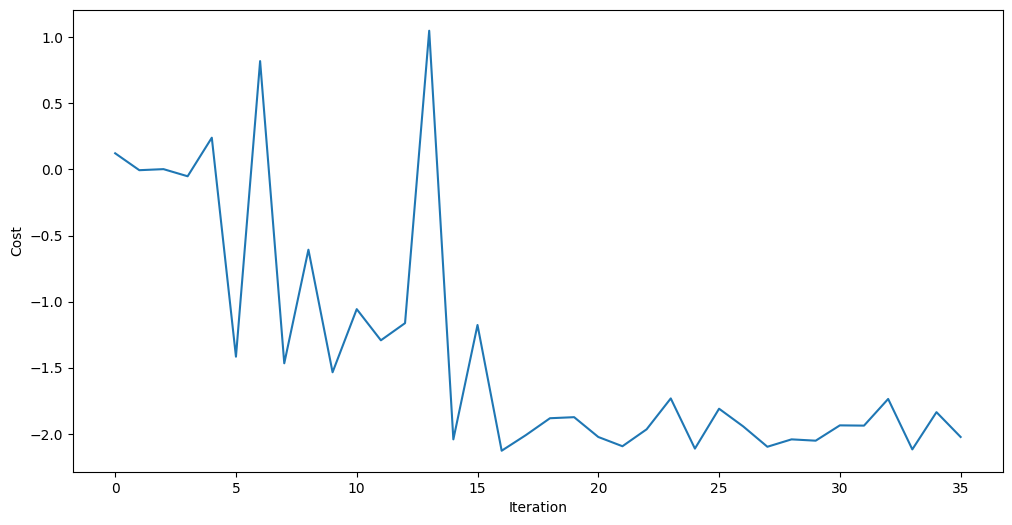

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

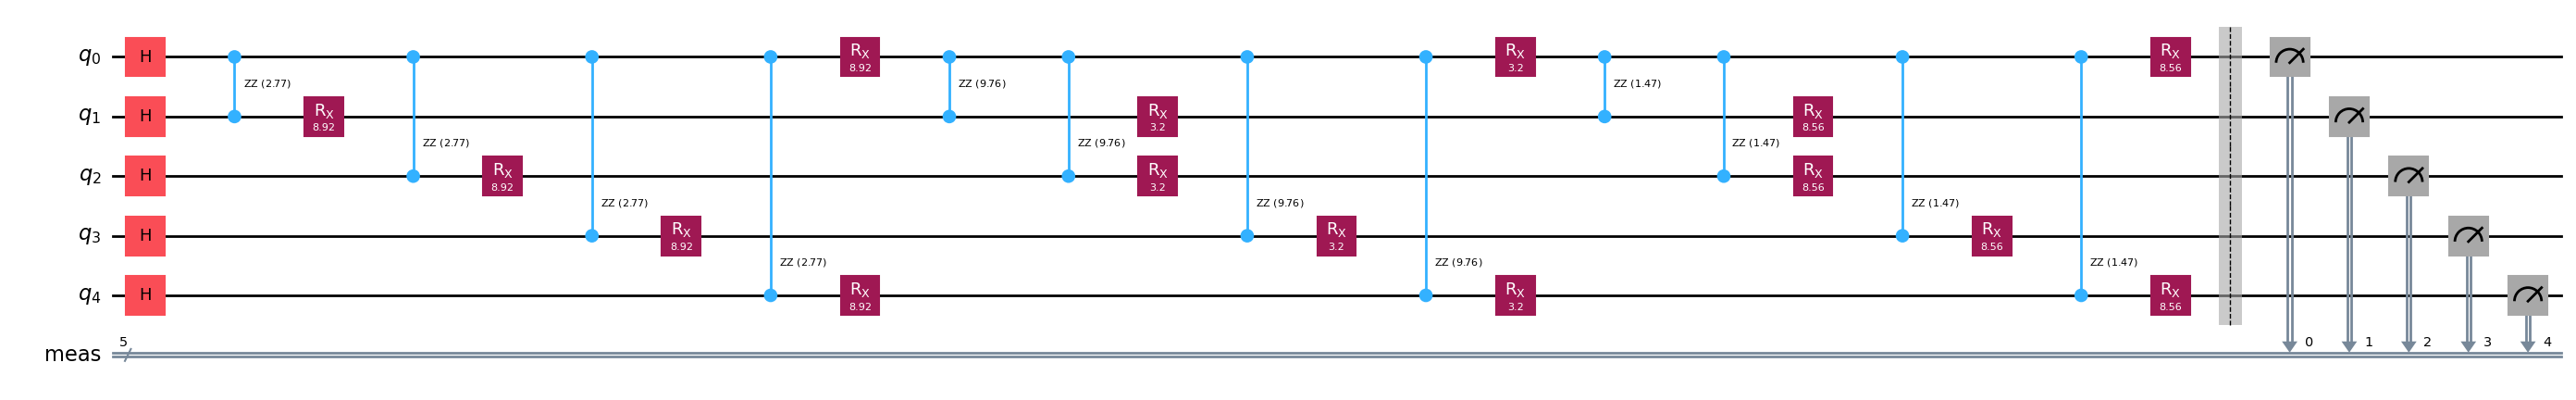

In [9]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.draw('mpl', fold=False, idle_wires=False)

In [10]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

# If using qiskit-ibm-runtime<0.24.0, change `mode=` to `backend=`
sampler = Sampler(mode=backend)
sampler.options.default_shots = 10000

# Set simple error suppression/mitigation options
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.twirling.enable_gates = True
sampler.options.twirling.num_randomizations = "auto"

pub= (optimized_circuit, )
job = sampler.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}
print(final_distribution_int)

{8: 0.0071, 1: 0.2661, 30: 0.2631, 14: 0.0276, 28: 0.027, 26: 0.0292, 2: 0.0079, 0: 0.0507, 16: 0.0085, 22: 0.0305, 31: 0.0524, 17: 0.0308, 3: 0.029, 5: 0.0294, 6: 0.0038, 18: 0.0055, 23: 0.0084, 9: 0.0296, 12: 0.0053, 15: 0.0101, 7: 0.0062, 29: 0.0092, 11: 0.0056, 4: 0.0088, 24: 0.0045, 19: 0.0052, 20: 0.005, 21: 0.0064, 13: 0.0062, 25: 0.0075, 27: 0.0074, 10: 0.006}


/home/ale/documents/qiskit/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:232: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


In [11]:
# auxiliary functions to sample most likely bitstring
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, len(graph))
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)

Result bitstring: [1, 0, 0, 0, 0]


1
2
10
7


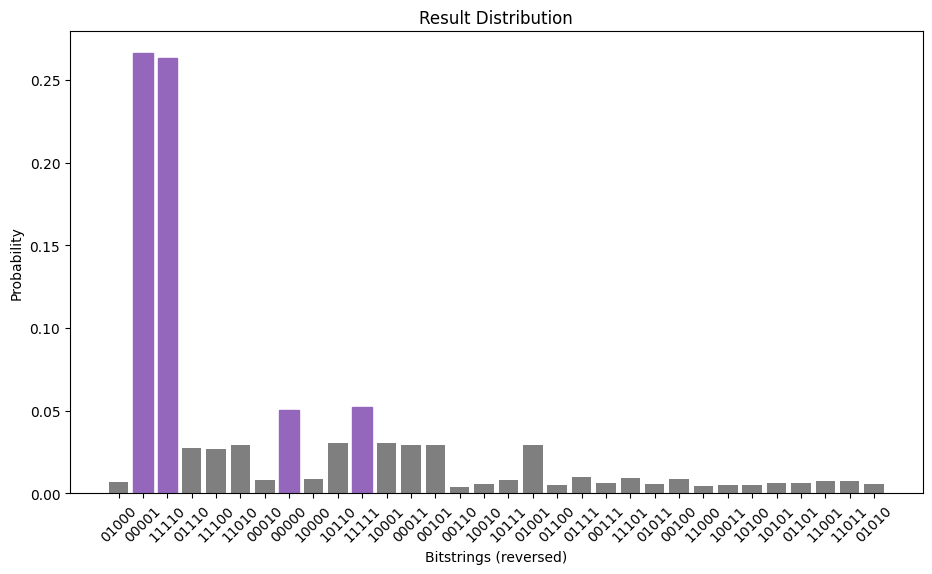

In [12]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update({"font.size": 10})
final_bits = final_distribution_bin
values = np.abs(list(final_bits.values()))
top_4_values = sorted(values, reverse=True)[:4]
positions = []
for value in top_4_values:
    ww = np.where(values == value)[0][0]
    print(ww)
    positions.append(ww)
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")
for p in positions:
    ax.get_children()[int(p)].set_color("tab:purple")
plt.show()

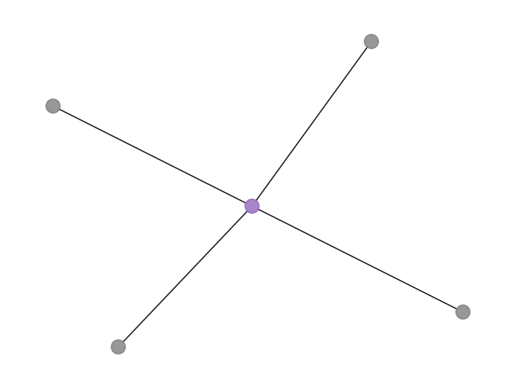

In [13]:
# auxiliary function to plot graphs
def plot_result(G, x):
    colors = ["tab:grey" if i == 0 else "tab:purple" for i in x]
    pos, default_axes = rx.spring_layout(G), plt.axes(frameon=True)
    rx.visualization.mpl_draw(G, node_color=colors, node_size=100, alpha=0.8, pos=pos)


plot_result(graph, most_likely_bitstring)

In [14]:
from typing import Sequence
def evaluate_sample(x: Sequence[int], graph: rx.PyGraph) -> float:
    assert len(x) == len(list(graph.nodes())), "The length of x must coincide with the number of nodes in the graph."
    return sum(x[u] * (1 - x[v]) + x[v] * (1 - x[u]) for u, v in list(graph.edge_list()))


cut_value= evaluate_sample(most_likely_bitstring, graph)
print('The value of the cut is:', cut_value)

The value of the cut is: 4
